# Webscraping das cotações do IDIV na B3

O presente script mostra como fazer o scraping de cotação do Índice de Dividendos diretamente do site da B3.

# Importações

In [21]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select

from time import sleep
from string import ascii_uppercase

from urllib.request import urlopen
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys

import os
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt

plt.style.use("ggplot")

---

# URL contendo os dados de cotações a serem raspadas

Foi criado uma classe de constantes, a fim de dar mais consistência ao código, bem como possibilitar\
a escolha de outros índices sem que haja uma confusão grande na escolha das URLs a serem raspadas.

In [2]:
class INDEX:
    IBOV = "http://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-estatisticas-historicas.htm"
    IDIV = "https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/indice-dividendos-idiv-estatisticas-historicas.htm"

---

# Configuração de drivers do Selenium

As configurações do Selenium usaram o webdriver do Firefox.

No entanto, é possível utilizar qualquer outra webdriver. Se esse for o caso, proceder com as alterações necessárias \
na função `set_driver()`.


In [4]:
def set_driver():
    opt = webdriver.FirefoxOptions()
    #opt.add_argument('--headless')
    opt.add_argument('--no-sandbox')
    opt.add_argument('--disable-dev-shm-usage')
    
    driver = webdriver.Firefox(options=opt)
    driver.header_overrides = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}
    driver.set_page_load_timeout(10)

    return driver

In [5]:
def parsing_url(url, driver):
    driver.maximize_window()
    driver.get(url)
    sleep(3)
    content = driver.page_source
    soup = BeautifulSoup(content, 'html.parser')

---

# Funções úteis para manipular as cotações no Excel

Como o título já diz, as funções abaixo são utilizadas para manipular e formatar as cotações raspadas
dentro de uma planilha Excel. 

A planilha será gerada no mesmo layout em que a tabela de cotação é exibida no site da B3.

## Função que remove os zeros da planilha

In [6]:
def del_zerosExcel(df, file_name, sheet_name):
    """
    Esta função deixa em branco as células que contiverem apenas
    o valor 0 nelas.

    :params
        df: Dataframe com os dados de cotação
        file_name: Nome do arquivo Excel onde as cotações foram salvas
        sheet_name: Nome da planilha Excel (aba interna do arquivo) - cada planilha corresponde a um ano
    """

    import openpyxl
    wb=openpyxl.load_workbook(file_name)
    sheet=wb[sheet_name]

    # necessário o +1 para percorrer até a última linha/coluna
    n_rows = range(len(df)+1) 
    n_cols = range(len(df.columns)+1)

    # foi adicionado +1 nos counters pq a contagem de linha/coluna começa em 1
    # e o counter começa em 0
    for c in n_cols:
        c += 1
        for r in n_rows:
            r += 1
            if (sheet.cell(row=r, column=c).value == 0.0):
                sheet.cell(row=r, column=c).value = None

    wb.save(file_name)
    wb.close()

## Passa os dados dos dfs para o Excel

In [7]:
def write_toExcel(dict_df, file_name):
    """
    Esta função irá ler o dicionário contendo os dataframes com as cotações do índice.
    Cada dataframe corresponde a um ano.

    A função irá ler o dataframe, criará o arquivo Excel e irá formatar a planilha de
    acordo com o layout da B3.
    
    :params
        dict_df: Dicionário de dataframes, que contém os DFs das cotações
        file_name: Nome do arquivo Excel onde as cotações foram salvas
    """
    
    with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:

        for ano, df in dict_df.items():
            df.to_excel(writer, sheet_name=ano)

            workbook  = writer.book
            worksheet = writer.sheets[ano]

            cols = dict(zip(range(26), ascii_uppercase))
            row = len(df)
            format_range = '{}{}:{}{}'.format(cols[0], row, cols[len(df.columns)], row)

            format_num = workbook.add_format({'num_format': '#,##0.00'})    
            worksheet.set_column(format_range, 11, format_num)

        print('Planilha gerada com sucesso!')
    
    # Após criar o arquivo com os dados, itera pelas pastas de trabalho e retira os '0'
    # das células, deixando-as vazias, conforme o arquivo original da B3
    for ano, df in dict_df.items():
        del_zerosExcel(df, file_name, ano)

---

# Formata o dataframe contendo as cotações


Formata o dataframe para que as pontuações sejam utiizadas no formato BR.

In [8]:
def format_merged_df(df):
    df['Pregão'] = df['Pregão'].astype('int')
    df.reset_index(inplace=True)
    df.set_index('Pregão', inplace=True)
    df.drop(columns=['index'], inplace=True)

    # Percorre todos os meses, exceto a coluna 'pregão'
    for mes in df.columns:
        if mes == 'Pregão':
            continue
        
        # replace feito devido às diferenças entre os separadores de milhar e decimal no BR e US
        for k, v in enumerate(df[mes]):        
            try:
                df.loc[df.index[k], mes] = float(v.replace('.','').replace(',', '.'))
            except ValueError:
                df.loc[df.index[k], mes] = 0
    
    return df

# Cria lista com as opções de semestre e ano

Aqui são criadas as listas com as possíveis opções que constam no site da B3.

Essa lista contém os anos disponíveis e as opções de semestre

In [9]:
def create_opt_lists(driver, lst_ano):
    """
    A partir de uma lista de anos passada como parâmetro, esta função irá
    verificar se eles existem no site da B3 e irá criar uma lista dos anos
    existentes para as cotações do índice selecionado.    

    :params
        driver: O driver Selenium criado para fazer o webscraping
        lst_ano: Lista dos anos a serem raspados no site da B3

    return: Retorna duas listas; a primeira, retorna uma lista com os anos disponíveis
            para escolha no listbox do site; a segunda retorna os semestres disponíveis.
    """

    # Lista com os anos disponíveis no site da B3
    lst_ano = lst_ano

    # Caso não tenha sido passado nenhuma lista customizada
    # busca todos os anos disponíveis na B3
    if not lst_ano:
        opt_ano = driver.find_element(By.ID, 'selectYear')
        options = [x for x in opt_ano.find_elements(By.TAG_NAME, "option")]

        for element in options:
            lst_ano.append(element.get_attribute('value'))

    # Lista com os dois semestres do ano
    lst_semestre = ['1º semestre', '2º semestre']

    return lst_ano, lst_semestre

# Função que faz  o scraping das cotações

In [30]:
def scrap_ibov(driver, file_name, years_list=[], create_excel=False):
   
    try:
        print("Iniciando o scraping dos dados...")
        print("Esta operação pode levar alguns minutos.")

        years_list = years_list

        # Muda para o frame que contém a tabela com os fechamentos
        frame = driver.find_element("xpath", "/html/body/main/div[4]/div/div[1]/div[1]/div/form/section/div/div/div/iframe")
        driver.switch_to.frame(frame)
        sleep(2)
        
        # Cria as listas com os anos e semestres para consulta
        # years_list em branco irá buscar todos os anos listados como opção na B3
        years_list, lst_semestre = create_opt_lists(driver, years_list)
        years_list.sort(reverse=True)

        # Cria um dicionário de DF, com um DF para cada ano
        dict_df = {ano: pd.DataFrame() for ano in years_list}   

        # Itera entre os anos escolhidos
        for ano in years_list:
            btn_ano = driver.find_element(By.ID, "selectYear")
            select = Select(btn_ano)
            select.select_by_value(ano)

            # Cria uma lista para cada semestre
            lst_sem1 = []
            lst_sem2 = []

            # Itera entre os dois semestres
            for k, v in enumerate(lst_semestre):                
                # seleciona o semestre a ser feito o scrap
                btn_sem = driver.find_elements("xpath","/html/body/app-root/app-daily-evolution/div/div/div[1]/form/div[1]/div[2]/div/select")
                btn_sem[0].send_keys(lst_semestre[k])
                sleep(2)
                
                # Se 1o semestre
                if k == 0:

                    # Busca a tabela com as cotações
                    tag = driver.find_elements(By.TAG_NAME, 'tr')

                    # itera pelas datas
                    for d in range(1, 32):
                        # busca as colunas referentes à cada data
                        td = tag[d].find_elements(By.TAG_NAME, 'td')
                        
                        lst_sem1.append(
                            {
                                'Pregão':td[0].text, 
                                'JAN':td[1].text, 
                                'FEV':td[2].text, 
                                'MAR':td[3].text, 
                                'ABR':td[4].text, 
                                'MAI':td[5].text, 
                                'JUN':td[6].text
                            }
                        )

                else:
                    tag = driver.find_elements(By.TAG_NAME, 'tr')
                    for d in range(1, 32):
                        td = tag[d].find_elements(By.TAG_NAME, 'td')

                        lst_sem2.append(
                            {
                                'Pregão':td[0].text, 
                                'JUL':td[1].text, 
                                'AGO':td[2].text, 
                                'SET':td[3].text, 
                                'OUT':td[4].text, 
                                'NOV':td[5].text, 
                                'DEZ':td[6].text
                            }
                        )
    
            # Junta os dois semestres num único DF
            df_ano = pd.merge(pd.DataFrame.from_records(lst_sem1), pd.DataFrame.from_records(lst_sem2), on="Pregão", how="outer")
            
            # Formata o DF, para proceder com o correto salvamento dos dados no Excel
            df_ano = format_merged_df(df_ano)

            # Insere o Df criado do dicionário
            dict_df[ano] = df_ano
        
            print(f'Scraping do ano {ano} realizado com sucesso!')

    except Exception as e:
        print('Erro ao tentar realizar o scraping: ' + e)
        return    

    if create_excel:
        print('Gerando planilha excel...')        
        write_toExcel(dict_df, file_name)
    
    # Encerra o scraping, fechando o driver
    print('Scraping dos dados finalizado.\n')

    return dict_df

---

# Criação do dataframe com os dados raspados

No dicionário de dados, cada ano é um índice.\
Esta função irá percorrer o dicionário, criando um dataframe para cada ano existente.

In [11]:
def create_df(data_dict: dict) -> pd.DataFrame:
    """
        No dicionário de dados, cada ano é um índice.
        Esta função irá percorrer o dicionário, criando um dataframe para cada ano existente.
        Após isso, a função irá concatenar os dataframes num único df, que irá conter todos os
        dados de cotação existentes no dicionário.

    :params
        data_dict: Dicionário com os dados obtidos na raspagem do site da B3

    return: Dataframe com os dados do dicionário
    """

    # Lista para armazenar os DF de cada ano
    dfs = []

    # Itera sobre as chaves e valores do dicionário
    for year, data in data_dict.items():
        # Cria um DF para o ano atual
        df_year = pd.DataFrame(data)

        # Adiciona a coluna 'Pregão', que representa o dia
        df_year['Pregão'] = df_year.index

        # Reordena as colunas
        df_year = df_year[['Pregão', 'JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ']]

        # Adiciona uma coluna 'Ano', a fim de identificar qual o ano
        # aquela linha de dados representa
        df_year['Ano'] = year

        dfs.append(df_year)

    # Concatena num só dataframe todos os criados anteriormente
    df_final = pd.concat(dfs, ignore_index=True)

    # Reordena os dados do dataframe final
    df_final = df_final.sort_values(by=['Ano', 'Pregão'])

    return df_final

O dataframe com todos os dados consolidados segue o padrão da tabela de onde os dados foram raspados, ou seja,\
cada linha representa um dia, de 1 a 31, e as colunas representam os meses.

Queremos um dataframe que siga uma série temporal, com cada linha representando uma data, usando o formato AAAA-MM-DD,\
e a cotação do respectivo dia.

In [12]:
def format_df(df: pd.DataFrame) -> pd.DataFrame:
    """
        Esta função irá criar um novo dataframe, com base nos dados do dataframe
        enviado via parâmetro. A função irá criar um dataframe com os campos Data e
        Cotação somente, sendo que a data ficará no formato YYYY-MM-DD.
    
    :params
        df: Dataframe com os dados crus vindo da raspagem do site da B3.
    
    return: Dataframe devidamente formatado, com cada linha representando um dia e a 
            cotação de fechamento deste dia.
    """

    # Dicionário com os meses (colunas) do dataframe original e seus respectivos
    # números
    months_dict = {
        "JAN": "01", "FEV": "02", "MAR": "03", "ABR": "04", "MAI": "05", "JUN": "06",
        "JUL": "07", "AGO": "08", "SET": "09", "OUT": "10", "NOV": "11", "DEZ": "12"
    }


    # Lista para armazenar as linhas criadas
    new_rows = []

    # Lista com as colunas do dataframe original
    #months_list = ['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ']
    months_list = df.columns[1:-1]

    # Itera sobre as linha do Df passado via parâmetro
    for _, row in df.iterrows():
        day = row['Pregão']
        year = row['Ano']

        for month in months_list:
            value = row[month]

            if value != 0:
                # Obtém o número do mês a partir do dicionário
                month_num = months_dict[month]

                # Cria a string que representa a data formadata
                date_str = f"{year}-{month_num}-{day}"

                # converte a string para datetime
                date = datetime.strptime(date_str, "%Y-%m-%d")

                # Adiciona a nova linha na lista
                new_rows.append({
                    "Data": date,
                    "Cotação": value
                })
    
    # Cria o dataframe devidademnte formatado
    new_df = pd.DataFrame(new_rows)
    
    # Organiza o df
    new_df = new_df.sort_values(by="Data")

    # Seta a Data como índice
    new_df = new_df.set_index(keys='Data')

    return new_df

---

# Roda o crawler


Irá rodar o script de webscraping, capturando os dados de cotação dos anos e semestres selecionados.\
Ao final, será retornado um dicionário de dataframes contendo as cotações.

Caso o usuário queira, será gerado uma planilha Excel com o layout utilizado pela B3

In [54]:
def run_crawler(index_url, years_list=["2023", "2024"], create_excel=False, file_name="cotações.xlsx") -> pd.DataFrame:
    """
    Função que roda o web scraper, realizado a raspagem dos dados do índice selecionado e gerando um dataframe com os dados.
    Ela também gera um excel das cotações, se o usuário assim desejar.

    :params
        index_url: URL de onde os dados serão raspados.
        years_list: Lista dos anos a serem raspados.
        create_excel: Informa se deve ser criada uma planilha com os dados.
        file_name: Nome do arquivo Excel que será criado.

    return: Dataframe com os dados de cotação do índice selecionado
    """
    driver = set_driver()
    parsing_url(index_url, driver)

    # procede com o scraping
    dic = scrap_ibov(driver, file_name, years_list, create_excel)
    driver.quit()

    df = create_df(dic)
    df = format_df(df)

    return df

## Salva os dados da raspagem num arquivo

Função simples para gerar uma persistência dos dados raspados.

Utilizei o formato `.parquet` para tal. Futuramente, colocarei as informações no
`SQLite`, para fins de estudo.

In [29]:
def save_data(df: pd.DataFrame, file_name="data"):
    folder_name = "data"
    file_name = f"{file_name}.parquet"
    file_path = os.path.join(os.getcwd(), folder_name, file_name)

    # Verifique se o arquivo já existe
    if os.path.exists(file_path):
        
        # Exclua o arquivo se ele já existir
        os.remove(file_path)    
    
    print(f"Salvando os dados raspados em: {file_path}")
    df.to_parquet(file_path)                      
    print(f"DataFrame salvo!\n")

Busca as informações desejadas

In [47]:
def load_file(file_name) -> pd.DataFrame:
    """
    Função que lê um arquivo parquet contendo as informações de cotações
    que foram raspadas no site da B3.

    :params
        file_name: O nome do arquivo com as cotações. 
            IMPORTANTE: Informar somente o nome, sem a extensão.
    
    return: Dataframe com os dados de cotação do arquivo selecionado
    """

    # Nome do arquivo a ser lido
    file_name = f"{file_name}.parquet"

    # Construa o caminho completo do arquivo
    folder_name = 'data'
    file_path = os.path.join(os.getcwd(), folder_name, file_name)

    # Verifique se o arquivo existe antes de tentar lê-lo
    if os.path.exists(file_path):

        # Leia o arquivo usando o Pandas
        df = pd.read_parquet(file_path)
        print("DataFrame carregado com sucesso!")
        return df

    else:
        print(f"O arquivo '{file_path}' não existe.")
        return None

---

## Verifica se o arquivo de cotações já existe, senão roda o crawler

In [55]:
def process_data(file_name, index_url, years_list=["2023", "2024"]) -> pd.DataFrame:
    """
    A função verifica se o arquivo de cotações informado no parâmetro já existe. Se existir, carrega ela
    num dataframe. Senão, procede com a raspagem do índice informado no parâmetro index_url.

    :params
        file_name: O nome do arquivo com as cotações.
            IMPORTANTE: Informar somente o nome, sem a extensão.
        index_url: URL de onde os dados serão raspados.
        years_list: Lista dos anos a serem raspados.
    
    return: Dataframe com os dados de cotação do índice selecionado
    """
    file_name = file_name.lower()

    # Verificar se o arquivo parquet correspondente já existe
    df = load_file(file_name)
    if df is None:
        # Se o arquivo não existe, executar o crawler
        df = run_crawler(index_url, years_list)

        # Salvar os dados no arquivo parquet
        save_data(df, file_name=file_name)
        
    return df

In [46]:
years = ["2010", "2011", "2012", "2013", "2014", "2015",
         "2016", "2017", "2018", "2019", "2020", "2021",
         "2022", "2023", "2024"]

df_idiv = process_data("idiv", years_list=years)
df_ibov = process_data("ibov", index_url=INDEX.IBOV, years_list=years)

DataFrame carregado com sucesso!
O arquivo 'e:\OneDrive\Dev\Python\Mercado Financeiro\Finance\Scraping\Scraping Cotação IDIV\data\ibov.parquet' não existe.
Confira o nome do arquivo informado ou proceda com a raspagem dos dados!


Iniciando o scraping dos dados...
Esta operação pode levar alguns minutos.
Scraping do ano 2024 realizado com sucesso!
Scraping do ano 2023 realizado com sucesso!
Scraping do ano 2022 realizado com sucesso!
Scraping do ano 2021 realizado com sucesso!
Scraping do ano 2020 realizado com sucesso!
Scraping do ano 2019 realizado com sucesso!
Scraping do ano 2018 realizado com sucesso!
Scraping do ano 2017 realizado com sucesso!
Scraping do ano 2016 realizado com sucesso!
Scraping do ano 2015 realizado com sucesso!
Scraping do ano 2014 realizado com sucesso!
Scraping do ano 2013 realizado com sucesso!
Scraping do ano 2012 realizado com sucesso!
Scraping do ano 2011 realizado com sucesso!
Scraping do ano 2010 realizado com sucesso!
Scraping dos dados finalizado.

Salvando os dados raspados em: e:\OneDrive\Dev\Python\Mercado Financeiro\Finance\Scraping\Scraping Cotação IDIV\data\ibov.parquet
DataFrame salvo!



---

# Plota as cotações raspadas

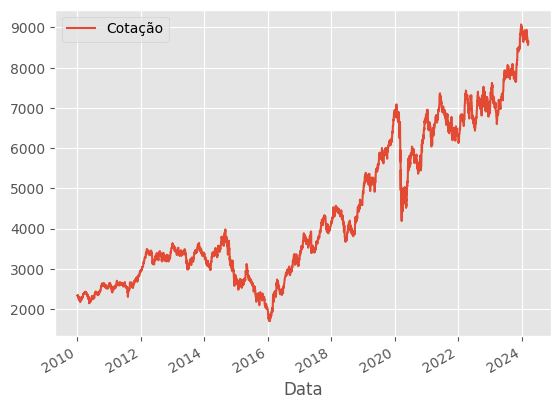

In [48]:
df_idiv.plot();

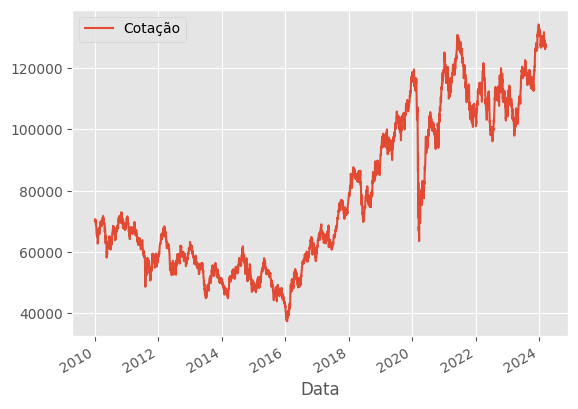

In [49]:
df_ibov.plot();

## Plota o retorno dos índices

### Retorno diário e o retorno acumulado

In [50]:
idiv_ret = df_idiv["Cotação"].pct_change()
ibov_ret = df_ibov["Cotação"].pct_change()

In [51]:
idiv_cum_rets = ((1 + idiv_ret).cumprod() - 1) * 100
ibov_cum_rets = ((1 + ibov_ret).cumprod() - 1) * 100

### Retorno total no período

In [52]:
idiv_tot_ret = (idiv_ret + 1).prod() - 1
ibov_tot_ret = (ibov_ret + 1).prod() - 1

## Plota os retornos

Retorno do IDIV no período: 270.16%
Retorno do IBOV no período: 82.07%


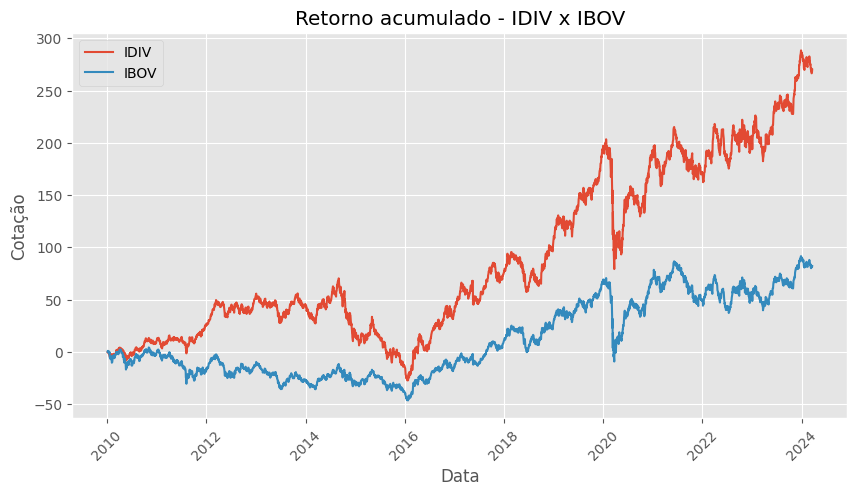

In [53]:
print(f"Retorno do IDIV no período: {idiv_tot_ret:.2%}")
print(f"Retorno do IBOV no período: {ibov_tot_ret:.2%}")

plt.figure(figsize=(10,5))

plt.plot(idiv_cum_rets.index, idiv_cum_rets.values, label='IDIV')
plt.plot(ibov_cum_rets.index, ibov_cum_rets.values, label='IBOV')

plt.xlabel('Data')
plt.ylabel('Cotação')
plt.title('Retorno acumulado - IDIV x IBOV')

# Adicionar uma legenda
plt.legend()

# Rotacionar a legenda do eixo x em 45 graus
plt.xticks(rotation=45)

plt.show()